# DAX Benchmarks - Unified Star Schema vs Star Schema

## Datasets
### Star Schema
![Star Schema](Star%20Schema.png)

### Unified Star Schema
![Unified Star Schema](Unified%20Star%20Schema.png)

## Requirements

In [229]:
%pip install -q plotly kaleido==0.2.1

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 9, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [230]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import sempy.fabric as fabric
import time

from plotly.subplots import make_subplots

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 11, Finished, Available, Finished)

In [231]:
pio.renderers.default = "png"

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 12, Finished, Available, Finished)

## Parameters

In [232]:
WORKSPACE = None  # same workspace as notebook/lakehouse; set name/ID if needed

DATASETS = {
    "SS": "Star Schema",
    "USS": "Unified Star Schema",
}

WARMUP_RUNS = 2
MEASURED_RUNS = 10

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 13, Finished, Available, Finished)

## Helpers

In [233]:
# Global accumulator for all runs
GLOBAL_RUNS = []

# Fact table mapping
FACT_FOR_MEASURE_PREFIX = {
    "SS": {
        "fact": "fact__sales",
        "fact_ret": "fact__returns",
        "fact_inv": "fact__inventory",
    },
    "USS": {
        "fact": "_bridge",
        "fact_ret": "_bridge",
        "fact_inv": "_bridge",
    }
}

# Use Hex codes for Plotly compatibility (C0=Blue, C1=Orange)
DATASET_COLORS = {
    "Star Schema": "#1f77b4",
    "Unified Star Schema": "#ff7f0e"
}

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 14, Finished, Available, Finished)

In [234]:
def run_one_dax(dataset_name: str, dax: str, workspace=None) -> pd.DataFrame:
    return fabric.evaluate_dax(dataset=dataset_name, dax_string=dax, workspace=workspace)

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 15, Finished, Available, Finished)

In [235]:
def run_query(dataset_name: str, suite_key: str, group_name: str, qname: str, dax: str, workspace=None):
    """
    Runs warmups + measured repetitions.
    Stops immediately on error.
    """
    runs_rows_local = []
    seq = 0
    stop_reason = "completed"

    def record(run_phase: str, rep_n: int, duration_ms: float, df, err: str | None):
        nonlocal seq
        seq += 1
        row_count = None if df is None else int(len(df))
        col_count = None if df is None else int(df.shape[1])

        runs_rows_local.append({
            "dataset": dataset_name,
            "suite": suite_key,
            "query_group": group_name,
            "query_name": qname,
            "phase": run_phase,
            "repeat_n": rep_n,
            "seq_in_query": seq,
            "duration_ms": float(duration_ms),
            "row_count": row_count,
            "col_count": col_count,
            "error": err,
        })

    # ---- Warmups ----
    for w in range(1, WARMUP_RUNS + 1):
        t0 = time.perf_counter()
        df = None
        err = None
        try:
            df = run_one_dax(dataset_name, dax, workspace=workspace)
        except Exception as e:
            err = str(e)
        t1 = time.perf_counter()
        record("warmup", w, (t1 - t0) * 1000.0, df, err)
        
        if err:
            stop_reason = "error_in_warmup"
            runs_rows_local[-1]["stop_reason"] = stop_reason
            return runs_rows_local, stop_reason

    # ---- Measured ----
    for m in range(1, MEASURED_RUNS + 1):
        t0 = time.perf_counter()
        df = None
        err = None
        try:
            df = run_one_dax(dataset_name, dax, workspace=workspace)
        except Exception as e:
            err = str(e)
        t1 = time.perf_counter()
        record("measured", m, (t1 - t0) * 1000.0, df, err)

        if err:
            stop_reason = "error"
            runs_rows_local[-1]["stop_reason"] = stop_reason
            return runs_rows_local, stop_reason

    if runs_rows_local:
        runs_rows_local[-1]["stop_reason"] = stop_reason

    return runs_rows_local, stop_reason

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 16, Finished, Available, Finished)

In [236]:
def run_and_plot(group, name, template):
    print(f"--- Running {name} ({group}) ---")
    local_runs = []
    
    for suite_key, dataset_name in DATASETS.items():
        mapping = FACT_FOR_MEASURE_PREFIX[suite_key]
        dax = template.format(**mapping)
        
        # Call simplified run_query
        rr, stop_reason = run_query(
            dataset_name=dataset_name,
            suite_key=suite_key,
            group_name=group,
            qname=name,
            dax=dax,
            workspace=WORKSPACE
        )
        local_runs.extend(rr)
        print(f"[{suite_key}] Stop reason: {stop_reason}")
        
        if stop_reason != "completed":
            if rr:
                last_error = rr[-1].get("error")
                if last_error:
                    print(f"[{suite_key}] ERROR: {last_error}")
            # Stop if the first dataset fails
            break
        
    # Append to global
    GLOBAL_RUNS.extend(local_runs)
    
    # Plot
    df = pd.DataFrame(local_runs)
    if not df.empty:
        measured = df.query("phase == 'measured' and error.isna()")
        if not measured.empty:
            stats = measured.groupby("dataset")["duration_ms"].median().reset_index()
            
            fig = px.bar(
                stats, 
                x="duration_ms", 
                y="dataset", 
                orientation='h', 
                title=name,
                color="dataset",
                color_discrete_map=DATASET_COLORS,
                text_auto='.0f'
            )
            
            fig.update_layout(
                height=250, 
                margin=dict(l=0, r=0, t=40, b=0),
                template="plotly_white",
                showlegend=False,
                xaxis_title="Median Duration (ms)",
                yaxis_title=None
            )
            fig.show()

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 17, Finished, Available, Finished)

## Queries

### Single Fact

#### SF01 - Sales By Year

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 18, Finished, Available, Finished)

--- Running SF01_sales_by_year (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


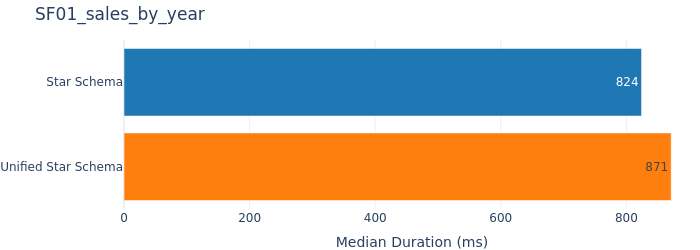

In [237]:
run_and_plot("Single Fact", "SF01_sales_by_year", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
ORDER BY 'dim__date'[year]
""")

#### SF02 - Sales By Year Category

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 19, Finished, Available, Finished)

--- Running SF02_sales_by_year_category (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


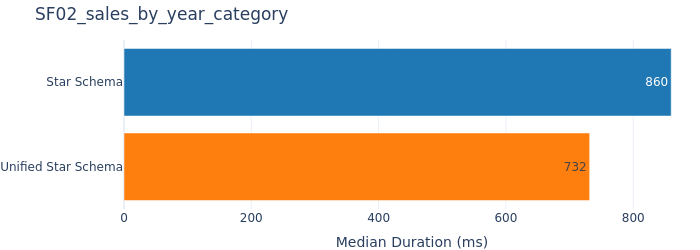

In [238]:
run_and_plot("Single Fact", "SF02_sales_by_year_category", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[category],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
ORDER BY 'dim__date'[year], 'dim__item'[category]
""")

#### SF03 - Sales Many Groups

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 20, Finished, Available, Finished)

--- Running SF03_sales_many_groups (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


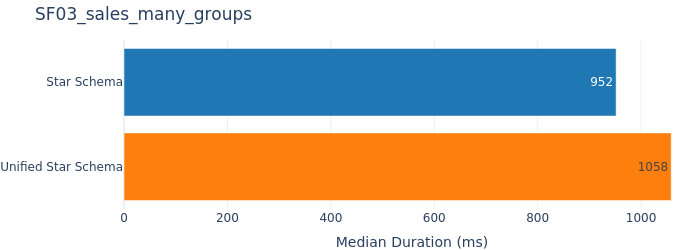

In [239]:
run_and_plot("Single Fact", "SF03_sales_many_groups", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[category],
    'dim__store'[_key__dim__store],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
""")

#### SF04 - Top 100 Items Sales 2002

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 21, Finished, Available, Finished)

--- Running SF04_top100_items_sales_2002 (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


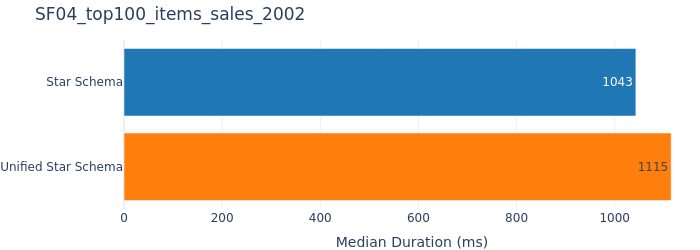

In [240]:
run_and_plot("Single Fact", "SF04_top100_items_sales_2002", """
EVALUATE
TOPN(
    100,
    SUMMARIZECOLUMNS(
        'dim__item'[_key__dim__item],
        'dim__item'[category],
        TREATAS( {{ 2002 }}, 'dim__date'[year] ),
        "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
    ),
    [Sales], DESC,
    'dim__item'[_key__dim__item], ASC
)
""")

#### SF05 - Inventory WH Category Year 2002

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 22, Finished, Available, Finished)

--- Running SF05_inventory_wh_category_year_2002 (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


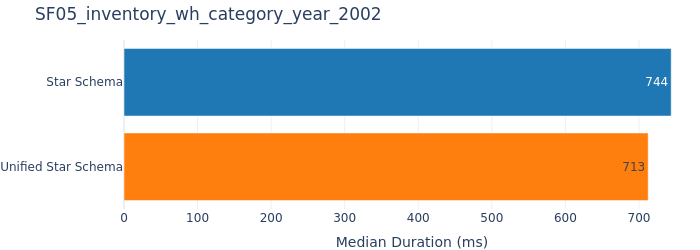

In [241]:
run_and_plot("Single Fact", "SF05_inventory_wh_category_year_2002", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__warehouse'[_key__dim__warehouse],
    'dim__item'[category],
    TREATAS( {{ 2002 }}, 'dim__date'[year] ),
    "Qty On Hand", SUM('{fact_inv}'[_measure__inventory__qty_on_hand])
)
""")

#### SF06 - Sales YoY By Year

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 23, Finished, Available, Finished)

--- Running SF06_sales_yoy_by_year (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


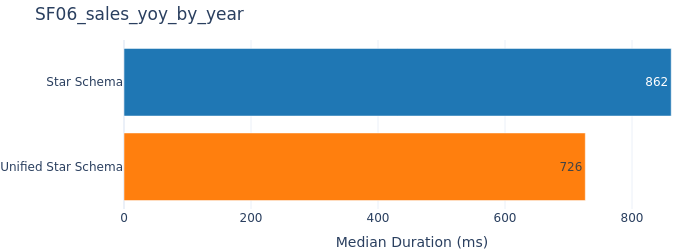

In [242]:
run_and_plot("Single Fact", "SF06_sales_yoy_by_year", """
EVALUATE
ADDCOLUMNS(
    SUMMARIZECOLUMNS(
        'dim__date'[year],
        "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
    ),
    "Sales PY",
        CALCULATE(
            SUM('{fact}'[_measure__sales__ext_sales_price]),
            SAMEPERIODLASTYEAR('dim__date'[date])
        ),
    "YoY Δ",
        SUM('{fact}'[_measure__sales__ext_sales_price])
        - CALCULATE(
            SUM('{fact}'[_measure__sales__ext_sales_price]),
            SAMEPERIODLASTYEAR('dim__date'[date])
        ),
    "YoY %",
        DIVIDE(
            SUM('{fact}'[_measure__sales__ext_sales_price])
            - CALCULATE(
                SUM('{fact}'[_measure__sales__ext_sales_price]),
                SAMEPERIODLASTYEAR('dim__date'[date])
            ),
            CALCULATE(
                SUM('{fact}'[_measure__sales__ext_sales_price]),
                SAMEPERIODLASTYEAR('dim__date'[date])
            )
        )
)
ORDER BY 'dim__date'[year]
""")

#### SF07 - Distinct Customers With Orders

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 24, Finished, Available, Finished)

--- Running SF07_distinct_customers_with_orders (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


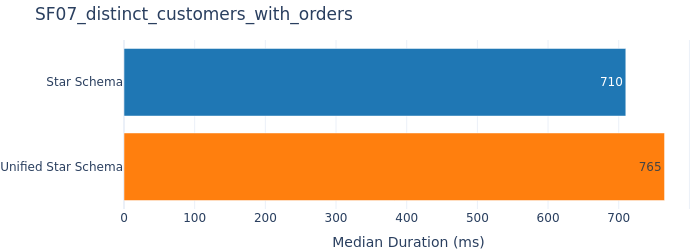

In [243]:
run_and_plot("Single Fact", "SF07_distinct_customers_with_orders", """
EVALUATE
ROW(
    "Distinct Customers With Orders",
    CALCULATE(DISTINCTCOUNT('{fact}'[_key__dim__customer]), NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price]))
)
""")

#### SF08 - Sales Hi Card Group

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 25, Finished, Available, Finished)

--- Running SF08_sales_hi_card_group (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


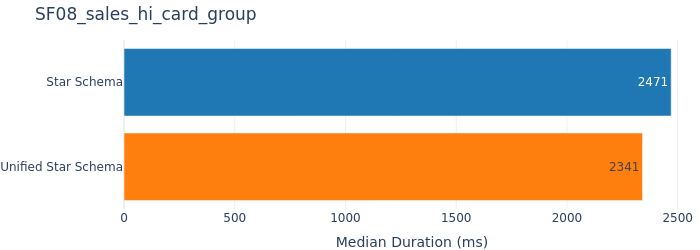

In [244]:
run_and_plot("Single Fact", "SF08_sales_hi_card_group", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
)
""")

#### SF09 - Top 500 Items By Year

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 26, Finished, Available, Finished)

--- Running SF09_top500_items_by_year (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


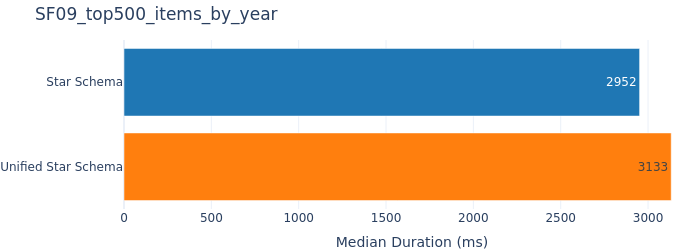

In [245]:
run_and_plot("Single Fact", "SF09_top500_items_by_year", """
EVALUATE
TOPN(
  500,
  SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__item'[_key__dim__item],
    'dim__item'[category],
    "Sales", SUM('{fact}'[_measure__sales__ext_sales_price])
  ),
  [Sales], DESC,
  'dim__date'[year], ASC,
  'dim__item'[_key__dim__item], ASC
)
""")

#### SF10 - Sales Rolling 90d By Category

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 27, Finished, Available, Finished)

--- Running SF10_sales_rolling_90d_by_category (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


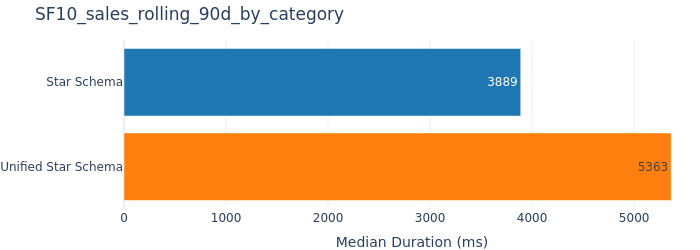

In [246]:
run_and_plot("Single Fact", "SF10_sales_rolling_90d_by_category", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__date'[month_of_year],
  'dim__item'[category],
  "Sales 90D",
    CALCULATE(
      SUM('{fact}'[_measure__sales__ext_sales_price]),
      DATESINPERIOD('dim__date'[date], MAX('dim__date'[date]), -90, DAY)
    )
)
""")

#### SF11 - New Customers YoY

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 28, Finished, Available, Finished)

--- Running SF11_new_customers_yoy (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


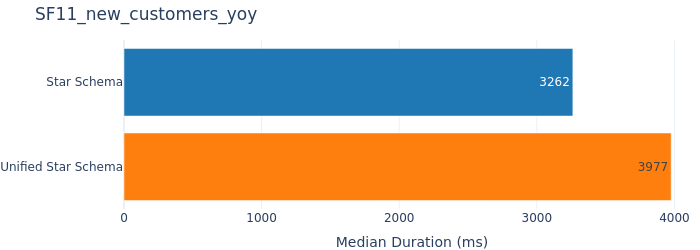

In [247]:
run_and_plot("Single Fact", "SF11_new_customers_yoy", """
EVALUATE
VAR CustThisYear =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustPriorYear =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    SAMEPERIODLASTYEAR('dim__date'[date]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
RETURN
ROW(
  "New Customers (YoY)",
  COUNTROWS( EXCEPT(CustThisYear, CustPriorYear) )
)
""")

#### SF12 - Distinct Customers Hi Card

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 29, Finished, Available, Finished)

--- Running SF12_distinct_customers_hi_card (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


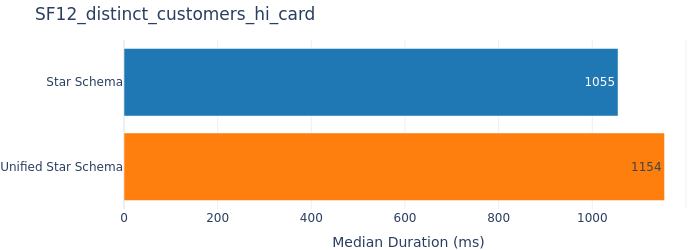

In [248]:
run_and_plot("Single Fact", "SF12_distinct_customers_hi_card", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  'dim__store'[_key__dim__store],
  "Distinct Customers",
    CALCULATE(
      DISTINCTCOUNT('{fact}'[_key__dim__customer]),
      NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
    )
)
""")

#### SF13 - Hi Card 30d Distinct Customers

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 30, Finished, Available, Finished)

--- Running SF13_hi_card_30d_distinct_customers (Single Fact) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


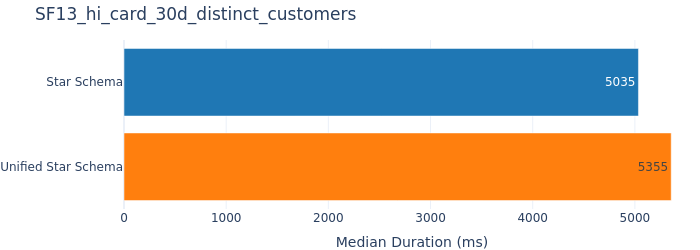

In [249]:
run_and_plot("Single Fact", "SF13_hi_card_30d_distinct_customers", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[_key__dim__item],
  "Distinct Customers 30D",
    CALCULATE(
      DISTINCTCOUNT('{fact}'[_key__dim__customer]),
      DATESINPERIOD('dim__date'[date], MAX('dim__date'[date]), -30, DAY)
    )
)
""")

### Multi Fact Aggregations

#### MF01 - Net Sales By Month

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 31, Finished, Available, Finished)

--- Running MF01_net_sales_by_month (Multi Fact Aggregations) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


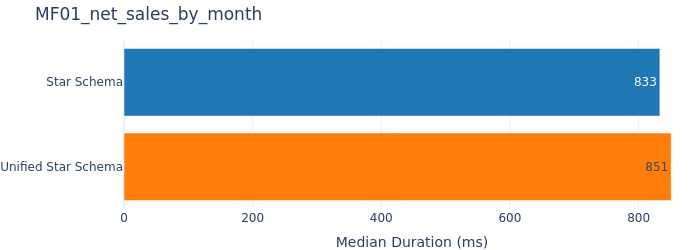

In [250]:
run_and_plot("Multi Fact Aggregations", "MF01_net_sales_by_month", """
EVALUATE
SUMMARIZECOLUMNS(
    'dim__date'[year],
    'dim__date'[month_of_year],
    "Sales",   SUM('{fact}'[_measure__sales__ext_sales_price]),
    "Returns", SUM('{fact_ret}'[_measure__returns__return_amt]),
    "Net",
        SUM('{fact}'[_measure__sales__ext_sales_price])
        - SUM('{fact_ret}'[_measure__returns__return_amt])
)
ORDER BY 'dim__date'[year], 'dim__date'[month_of_year]
""")

#### MF02 - Return Rate By Year Category

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 32, Finished, Available, Finished)

--- Running MF02_return_rate_by_year_category (Multi Fact Aggregations) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


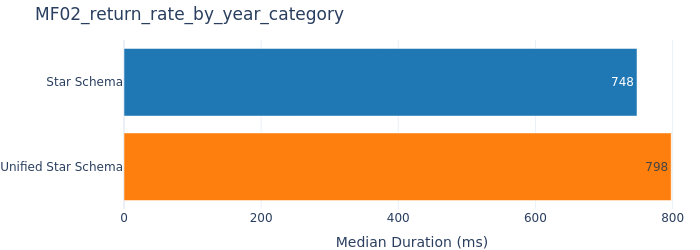

In [251]:
run_and_plot("Multi Fact Aggregations", "MF02_return_rate_by_year_category", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__item'[category],
  "Sales",   SUM('{fact}'[_measure__sales__ext_sales_price]),
  "Returns", SUM('{fact_ret}'[_measure__returns__return_amt]),
  "Return Rate",
    DIVIDE(
      SUM('{fact_ret}'[_measure__returns__return_amt]),
      SUM('{fact}'[_measure__sales__ext_sales_price])
    )
)
ORDER BY 'dim__date'[year], 'dim__item'[category]
""")

#### MF03 - Two Fact Separate Aggregates

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 33, Finished, Available, Finished)

--- Running MF03_two_fact_separate_aggregates (Multi Fact Aggregations) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


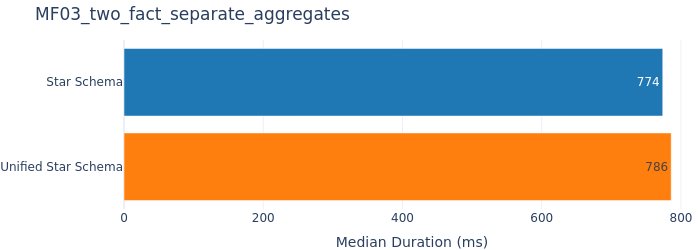

In [252]:
run_and_plot("Multi Fact Aggregations", "MF03_two_fact_separate_aggregates", """
EVALUATE
SUMMARIZECOLUMNS(
  'dim__date'[year],
  'dim__store'[_key__dim__store],
  "Sales (all items)",
    CALCULATE(
      SUM('{fact}'[_measure__sales__ext_sales_price]),
      REMOVEFILTERS('dim__item')
    ),
  "Returns (all reasons)",
    CALCULATE(
      SUM('{fact_ret}'[_measure__returns__return_amt]),
      REMOVEFILTERS('dim__reason')
    ),
  "Return Rate",
    DIVIDE(
      CALCULATE(
        SUM('{fact_ret}'[_measure__returns__return_amt]),
        REMOVEFILTERS('dim__reason')
      ),
      CALCULATE(
        SUM('{fact}'[_measure__sales__ext_sales_price]),
        REMOVEFILTERS('dim__item')
      )
    )
)
""")

### Cross Fact Set Operations

#### CF01 - Distinct Customers Sales Or Returns

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 34, Finished, Available, Finished)

--- Running CF01_distinct_customers_sales_or_returns (Cross Fact Set Ops) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


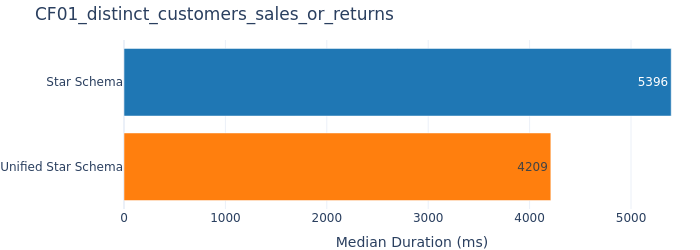

In [253]:
run_and_plot("Cross Fact Set Ops", "CF01_distinct_customers_sales_or_returns", """
EVALUATE
VAR CustSales =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustReturns =
  CALCULATETABLE(
    VALUES('{fact_ret}'[_key__dim__customer]),
    NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
  )
RETURN
ROW(
  "Distinct Customers (Sales OR Returns)",
  COUNTROWS( DISTINCT( UNION(CustSales, CustReturns) ) )
)
""")

#### CF02 - Customers Sales And Returns

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 35, Finished, Available, Finished)

--- Running CF02_customers_sales_and_returns (Cross Fact Set Ops) ---
[SS] Stop reason: completed
[USS] Stop reason: completed


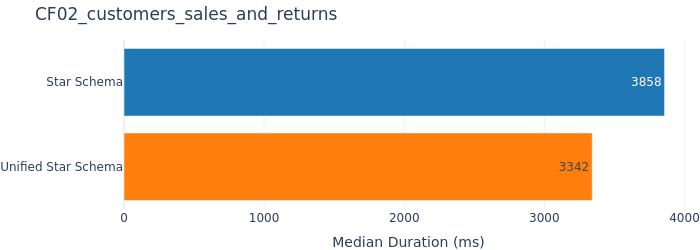

In [254]:
run_and_plot("Cross Fact Set Ops", "CF02_customers_sales_and_returns", """
EVALUATE
VAR CustSales =
  CALCULATETABLE(
    VALUES('{fact}'[_key__dim__customer]),
    NOT ISBLANK('{fact}'[_measure__sales__ext_sales_price])
  )
VAR CustReturns =
  CALCULATETABLE(
    VALUES('{fact_ret}'[_key__dim__customer]),
    NOT ISBLANK('{fact_ret}'[_measure__returns__return_amt])
  )
RETURN
ROW(
  "Customers (Sales AND Returns)",
  COUNTROWS( INTERSECT(CustSales, CustReturns) )
)
""")

## Summarize

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 36, Finished, Available, Finished)

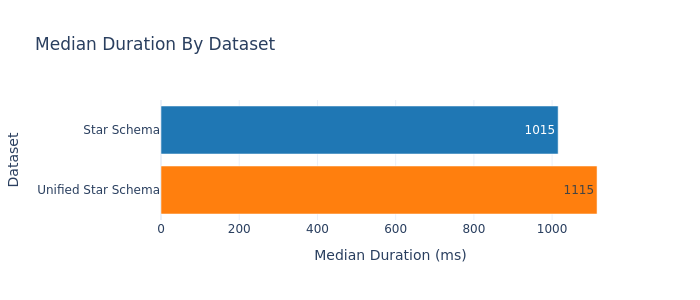

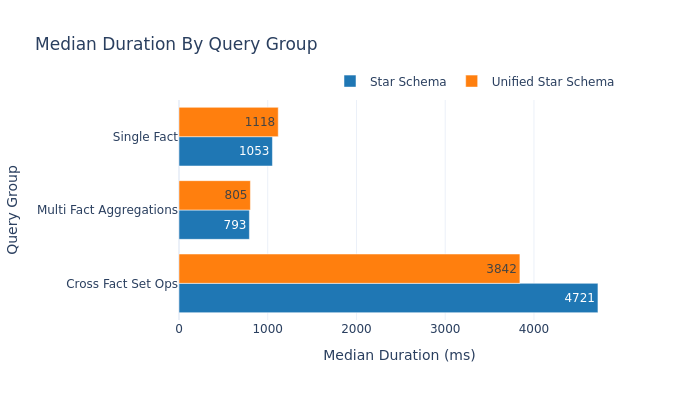

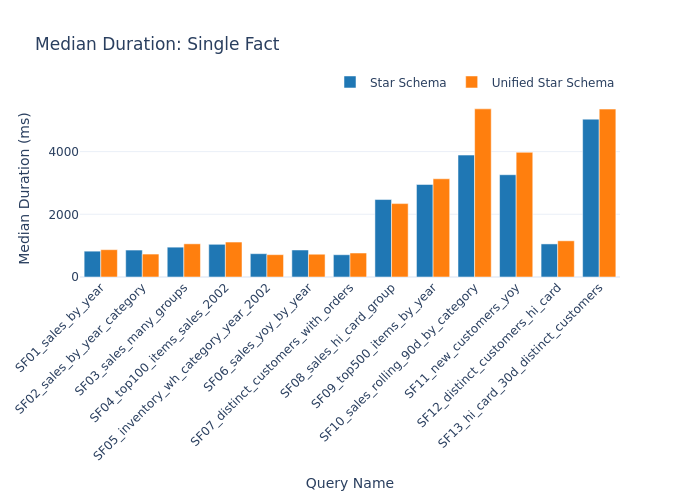

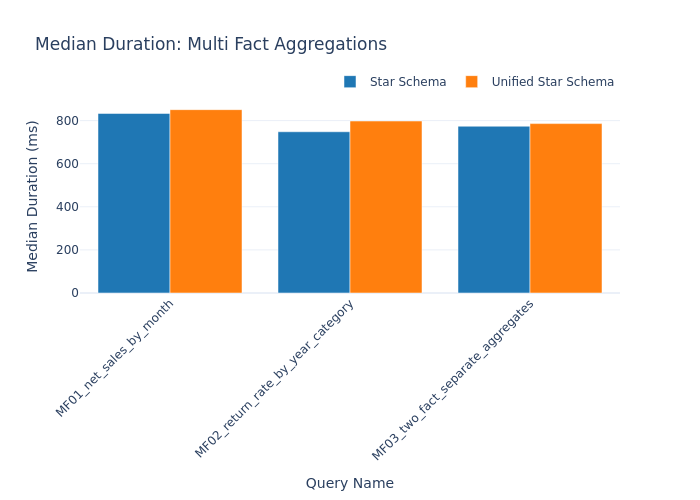

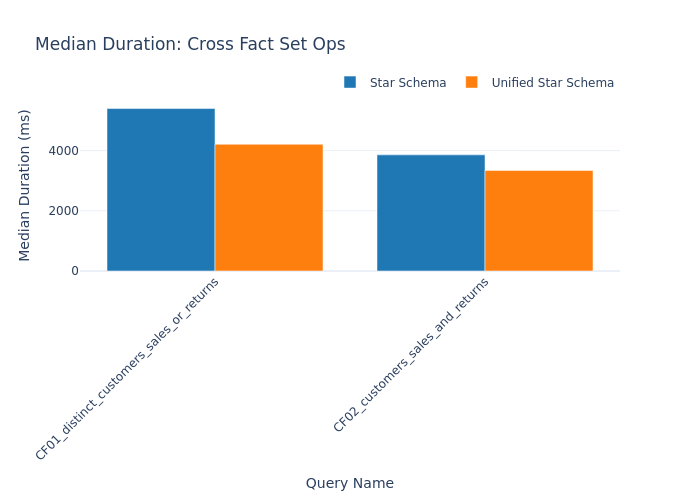

In [255]:
# Prepare data
filtered_df = pd.DataFrame(GLOBAL_RUNS).query("phase == 'measured' and error.isna()")

# 1. Median Duration by Dataset
dataset_stats = filtered_df.groupby("dataset")["duration_ms"].median().reset_index()
fig1 = px.bar(
    dataset_stats,
    x="duration_ms",
    y="dataset",
    orientation='h',
    title="Median Duration By Dataset",
    color="dataset",
    color_discrete_map=DATASET_COLORS,
    text_auto='.0f',
    labels={"duration_ms": "Median Duration (ms)", "dataset": "Dataset"}
)
fig1.update_layout(template="plotly_white", showlegend=False, height=300)
fig1.show()

# 2. Median Duration by Query Group
group_stats = filtered_df.groupby(["query_group", "dataset"])["duration_ms"].median().reset_index()
fig2 = px.bar(
    group_stats,
    x="duration_ms",
    y="query_group",
    color="dataset",
    barmode="group",
    orientation='h',
    title="Median Duration By Query Group",
    color_discrete_map=DATASET_COLORS,
    text_auto='.0f',
    labels={"duration_ms": "Median Duration (ms)", "query_group": "Query Group"}
)
fig2.update_layout(
    template="plotly_white", 
    height=400,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        title=""
    )
)
fig2.show()

# 3. Detailed Charts per Group
groups = ["Single Fact", "Multi Fact Aggregations", "Cross Fact Set Ops"]

for group_name in groups:
    group_df = filtered_df.query(f"query_group == '{group_name}'").groupby(["query_name", "dataset"])["duration_ms"].median().reset_index()
    
    if not group_df.empty:
        fig = px.bar(
            group_df,
            x="query_name",
            y="duration_ms",
            color="dataset",
            barmode="group",
            title=f"Median Duration: {group_name}",
            color_discrete_map=DATASET_COLORS,
            labels={"duration_ms": "Median Duration (ms)", "query_name": "Query Name"}
        )
        fig.update_layout(
            template="plotly_white", 
            xaxis_tickangle=-45,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1,
                title=""
            )
        )
        fig.show()

## Environment

In [256]:
# Install watermark if not already installed
try:
    import watermark
except ImportError:
    %pip -q install watermark

%load_ext watermark
%watermark -n -u -v -iv -w

StatementMeta(, 1e0dd36d-7cde-4354-a9a8-263852c61a35, 37, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Last updated: Tue, 30 Dec 2025

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.20.0

notebookutils: 1.1.12.35
pandas       : 2.1.4
plotly       : 5.22.0
pyspark      : 3.5.1.5.4.20240407
sempy        : 0.11.0

Watermark: 2.6.0

